# Multi-class Dog Breed Classification

This notebook will build a multi-class image classifier using Tensorflow 2.0 and Tensorflow Hub.

## Problem
 
Identifying the breed of a dog given an image of a dog using a neural network.

## Data

The data is from Kaggle's Dog Breed Identification competition that can be found [here](https://www.kaggle.com/competitions/dog-breed-identification/overview).

## Evaluation

According to the Kaggle's evaluation, we will be "evaluated on Multi Class Log Loss between the predicted probability and the observed target."

## Features
- We have images (unstructed data) so we'll be using a neural net/transfer learning.
- There are 120 breeds of dogs in the dataset thus there are 120 different classes.
- We are working with more than 10,000 images in the training set and 10,000 images in the test set.

## Getting The Workspace Ready

In [16]:
# Import tensorflow
import tensorflow as tf

print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.9.1


In [17]:
# Import tensorflow hub
import tensorflow_hub as hub

print(f"Tensorflow Hub Version: {hub.__version__}")

Tensorflow Hub Version: 0.12.0


In [18]:
# Check if GPU is available
print(f"GPU is{'' if tf.config.list_physical_devices('GPU') else ' not'} available")

GPU is available


## Data Preparation
As we are working with image data, we'll need to convert it into numeric data so that the models will be able to run on the dataset.

Let's first check the labels of our data.

In [37]:
import pandas as pd
import numpy as np

labels_csv = pd.read_csv("data/labels.csv")
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [20]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64


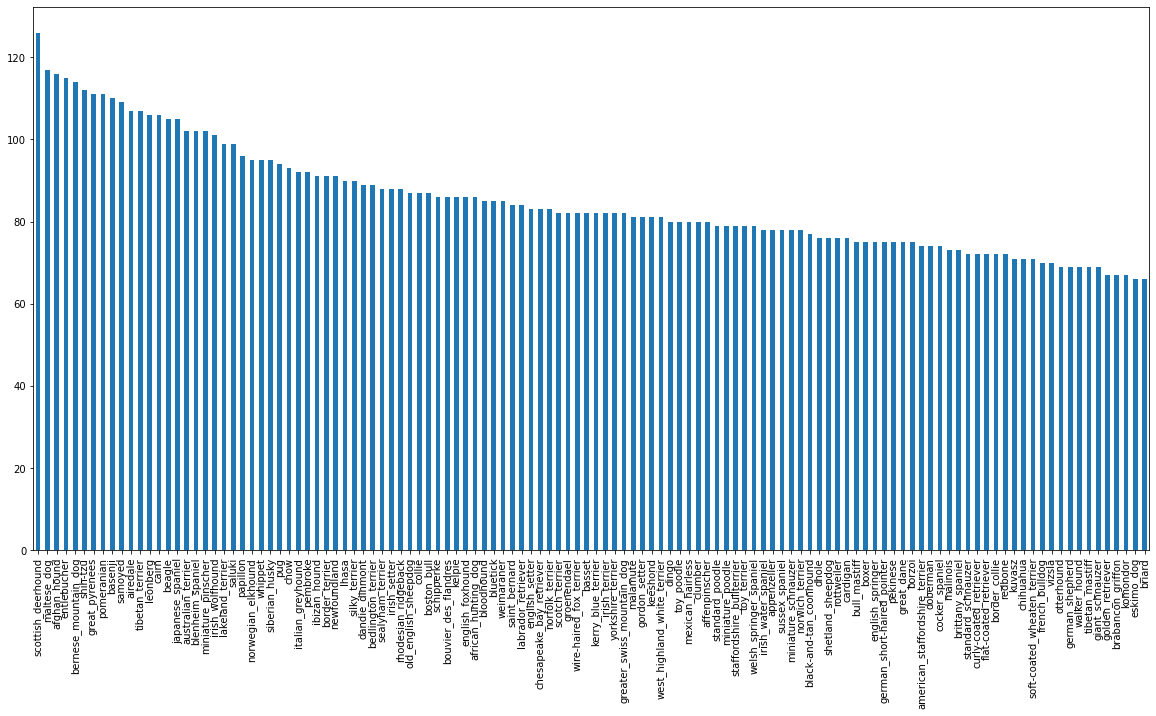

In [21]:
# How many images are there of each breed?
print(labels_csv["breed"].value_counts())
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));

It seems like the classes with the fewest images have 66 images which seems to be enough for building our model.

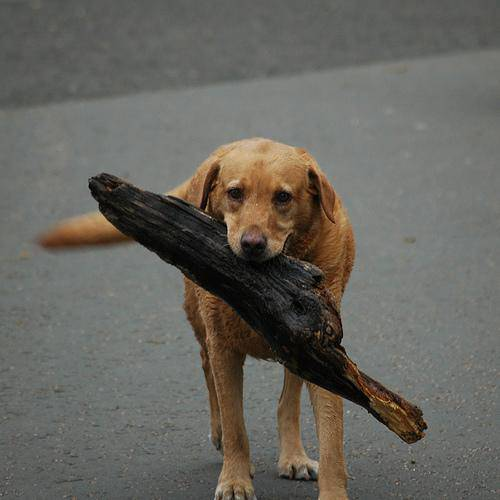

In [22]:
# Let's view one of our dog images
from IPython.display import Image

Image("data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg")

### Getting Images and Their Labels
Let's get a list of all our image file paths.

In [23]:
# Create file paths from our image ID's
file_paths = labels_csv["id"].apply(lambda x: "data/train/" + x + ".jpg").tolist()
file_paths[:10]

['data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [48]:
len(file_paths)

10222

In [24]:
# Check whether number of file paths match the actual number of training images
import os

if len(os.listdir("data/train")) == len(file_paths):
    print("Number of file paths match number of training images")
else:
    print("Number of file paths do not match")

Number of file paths match number of training images


### Preparing Labels
Let's look at our labels and prepare them as well.

In [34]:
# convert labels to numpy array
labels = labels_csv["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [35]:
# How many labels do we have
len(labels)

10222

In [36]:
# Make sure there are the same number of images and labels
if len(file_paths) == len(labels):
    print("Number of labels matches number of images")
else:
    print("Number of labels do not match number of images")

True

In [38]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [39]:
# Number of dog breeds should be 120
len(unique_breeds)

120

In [47]:
# One hot encode our labels where 1 represents that the label is that breed in the same position in the unique_breeds array
encoded_labels = [(label == unique_breeds).astype(int) for label in labels]
encoded_labels[:3]

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 

### Creating our Validation Set
As the data source (Kaggle) only provides a training and testing set, we will want to create our own validation set.

In [57]:
X = file_paths
y = encoded_labels

10222

As we have more than 10,000 images, we will start off by experimenting with ~1000 images, and increase the number as needed.

In [52]:
NUM_IMAGES = 1000

In [61]:
# Let's split out data into train and validation sets
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X[:NUM_IMAGES],
                                                      y[:NUM_IMAGES],
                                                      test_size=0.2,
                                                      random_state=42)

len(X_train), len(y_train), len(X_valid), len(y_valid)

(800, 800, 200, 200)

In [62]:
X_train[:2]

['data/train/00bee065dcec471f26394855c5c2f3de.jpg',
 'data/train/0d2f9e12a2611d911d91a339074c8154.jpg']

In [63]:
y_train[:2]

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]

## Preprocessing Images

We will be turning our images into tensors for our model.
To do this, we will be writing a function that:
1. Takes an image filepath as a parameter
2. Use TensorFlow to read the file and save it to a variable `image`
3. Turn our `image` jpg into tensors
4. Standardize our image (convert the colours from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
6. Return `image`

In [88]:
def process_image_path(file_path: str, img_size: int = 224) -> tf.Tensor:
    """
    Takes an image file path and turns the image into a tensor.

    :param file_path: File path of an image
    :param img_size: Size of the output image (default = 224x224)
    :return img: The image of the file path as a tensor
    """
    # Read in the image file
    img = tf.io.read_file(file_path)
    # Turn the image into a tensor
    img = tf.image.decode_image(img, channels=3)
    # Standardize the tensor
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize and return the image
    return tf.image.resize(img, [img_size, img_size])